In [2]:
import glob
import json
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm

from src.utils import DataGenerator, loss, make_callbacks, make_model, plot_history

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 32
        self.img_size = (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.n_blocks = 4
        self.emb_len = 1024
        self.kernel_size = (10, 3)
        self.act_fn = "relu"
        self.batch_norm = False
        self.n_epochs = 150
        self.input_shape = (self.img_size[0], self.img_size[1], self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
root_dir = "/app/_data/artist_data/"
mod_dir = "/app/_data/artist_data/models/test_arch/constr_3/"

In [5]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))

## train_val_split

In [6]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=6.
  warnings.warn(


In [7]:
artist_ids = train["artistid"].unique().tolist()
train_set = train[train["fold"] != cfg.fold]["artistid"].unique()
val_set = train[train["fold"] == cfg.fold]["artistid"].unique()
train_data, val_data = {}, {}
for art_id in tqdm(artist_ids):
    new_df = train.query("artistid == @art_id")
    paths = new_df["path"].values.tolist()
    tracks = new_df["trackid"].values.tolist()
    if art_id in train_set:
        train_data[art_id] = {
            "tracks": tracks,
            "paths": paths,
            "count": new_df.shape[0],
        }
    else:
        val_data[art_id] = {"tracks": tracks, "paths": paths, "count": new_df.shape[0]}

100% 18468/18468 [00:43<00:00, 427.61it/s]


## DataGenerator

In [65]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
        shuffle=True,
        positive_label=0,
    ):
        self.data = data
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        if self.n_chanels is None:
            self.n_chanels = 1
        self.shuffle = shuffle
        self.positive_label = positive_label
        self.negative_label = 0 if self.positive_label == 1 else 1
        self.artist_ids = [x for x in self.data.keys()]
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def __len__(self):
        return len(self.artist_ids) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels != 1:
            img = np.concatenate([img, img, img], -1)
        return img

    def make_pair(self, ix, same_artist=True):
        artist_id = self.artist_ids[ix]
        if self.data[artist_id]["count"] < 2:
            same_artist = False
        if same_artist:
            path1, path2 = rnd.sample(self.data[artist_id]["paths"], 2)
        else:
            path1 = rnd.sample(self.data[artist_id]["paths"], 1)[0]
            new_artist_id = artist_id
            while artist_id == new_artist_id:
                new_artist_id = rnd.sample(self.artist_ids, 1)[0]
                path2 = rnd.sample(self.data[new_artist_id]["paths"], 1)[0]
        return same_artist, (path1, path2)

    def _get_one(self, ix, same_artist):
        upd_same_artist, (path1, path2) = self.make_pair(ix=ix, same_artist=same_artist)
        img1 = self.load_img(path1)
        img2 = self.load_img(path2)
        y = self.positive_label if upd_same_artist else self.negative_label
        return (img1, img2), y

    def __getitem__(self, batch_ix):
        b_X1 = np.zeros(
            (self.batch_size, self.img_size[0], self.img_size[1], self.n_chanels),
            dtype=np.float32,
        )
        b_X2 = np.zeros(
            (self.batch_size, self.img_size[0], self.img_size[1], self.n_chanels),
            dtype=np.float32,
        )
        b_Y = np.zeros(
            self.batch_size,
            dtype=np.float32,
        )
        for i in range(self.batch_size):
            (b_X1[i], b_X2[i]), b_Y[i] = self._get_one(
                ix=i + self.batch_size * batch_ix, same_artist=np.random.random() > 0.5
            )

        return {"img1": b_X1, "img2": b_X2}, b_Y

In [66]:
train_gen = DataGenerator(
    data=train_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    positive_label=cfg.pos_label,
)
val_gen = DataGenerator(
    data=val_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=False,
    positive_label=cfg.pos_label,
)

In [10]:
ix = np.random.randint(train_gen.__len__())
imgs, targets = train_gen.__getitem__(ix)

In [11]:
# for i in range(cfg.batch_size):
#     p1, p2 = paths[i]
#     train.query('path == @p1')['artistid'].values[0] == train.query('path == @p2')['artistid'].values[0], targets[i]

In [67]:
train_gen.positive_label
train_gen.negative_label

0

1

## Build model

In [13]:
model = make_model(
    input_shape=cfg.input_shape,
    n_blocks=cfg.n_blocks,
    embedding_len=cfg.emb_len,
    kernel_size=cfg.kernel_size,
    activation_fn="relu",
    batch_norm=cfg.batch_norm,
)

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
callbacks = make_callbacks(
    path=mod_dir,
    monitor="val_loss",
    mode="min",
    reduce_patience=10,
    stop_patience=100,
)
# model.compile(
#     loss=contr_loss(margin=1),
#     optimizer=optimizer,
#     metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
# )
# model.compile(
#     loss='bce',
#     optimizer=optimizer,
#     metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
# )

In [71]:
def loss(margin=1):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


siamese.compile(
    loss=loss(margin=1),
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

In [60]:
shutil.rmtree(mod_dir)
shutil.rmtree(f"/app/.tensorboard/{mod_dir.split('/')[-2]}/")

In [ ]:
history = siamese.fit(
    x=train_gen,
    epochs=cfg.n_epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_data=val_gen,
    shuffle=True,
    steps_per_epoch=len(train_data) // cfg.batch_size,
    validation_steps=len(val_data) // cfg.batch_size,
    validation_freq=1,
    max_queue_size=10,
    workers=10,
    use_multiprocessing=False,
)

Epoch 1/150
479/480 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.7724 - precision_4: 0.7614 - recall_4: 0.7894
Epoch 1: val_loss improved from inf to 0.15030, saving model to /app/_data/artist_data/models/test_arch/constr_3/model.h5
480/480 [==============================] - 42s 83ms/step - loss: 0.1570 - accuracy: 0.7727 - precision_4: 0.7616 - recall_4: 0.7898 - val_loss: 0.1503 - val_accuracy: 0.7751 - val_precision_4: 0.7649 - val_recall_4: 0.7826 - lr: 0.0010
Epoch 2/150
479/480 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.7801 - precision_4: 0.7724 - recall_4: 0.7947
Epoch 2: val_loss improved from 0.15030 to 0.14492, saving model to /app/_data/artist_data/models/test_arch/constr_3/model.h5
480/480 [==============================] - 41s 83ms/step - loss: 0.1532 - accuracy: 0.7803 - precision_4: 0.7728 - recall_4: 0.7946 - val_loss: 0.1449 - val_accuracy: 0.7926 - val_precision_4: 0.8001 - val_recall_4: 0.7841 - lr: 0.0010
Epoc

In [19]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
def effmod(input_shape, embedding_len):
    base_model = keras.applications.EfficientNetV2B0(
        include_top=False,
        weights=None,
        input_shape=input_shape,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
        include_preprocessing=False,
    )
    base_model.add(keras.layers.Flatten())
    base_model.add(keras.layers.Dense(embedding_len, activation = 'sigmoid'))
    
    input_1 = keras.layers.Input(input_shape, name="img1")
    input_2 = keras.layers.Input(input_shape, name="img2")
    node1 = base_model(input_1)
    node2 = base_model(input_2)

    merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
    output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
    model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    return model

In [54]:
embedding_len = 1024
n_blocks = 4
kernel_size = (10, 3)
activation_fn = "relu"
batch_norm = False
depth_vector = 2 ** ((np.arange(n_blocks) + 1) * 2)
input_shape = (512, 81, 1)

input = tf.keras.Input(shape=(512, 81, 1), dtype="float32")
x = keras.layers.Conv2D(
    4,
    (5, 5),
    activation="tanh",
    name="Conv2D_1",
)(input)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_1")(x)
x = keras.layers.Conv2D(
    filters=16,
    kernel_size=kernel_size,
    activation="tanh",
    name="Conv2D_2",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_2")(x)
x = keras.layers.Conv2D(
    filters=64,
    kernel_size=kernel_size,
    activation="tanh",
    # name="Conv2D_3",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_3")(x)
x = keras.layers.Conv2D(
    filters=256,
    kernel_size=kernel_size,
    activation="tanh",
    name="Conv2D_4",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_4")(x)
x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(embedding_len, activation="tanh", name=f"dense_1024")(x)
embedding_net = keras.Model(inputs=input, outputs=x, name=f"embedding")


input_1 = keras.layers.Input(input_shape, name="input1")
input_2 = keras.layers.Input(input_shape, name="input2")
node1 = embedding_net(input_1)
node2 = embedding_net(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

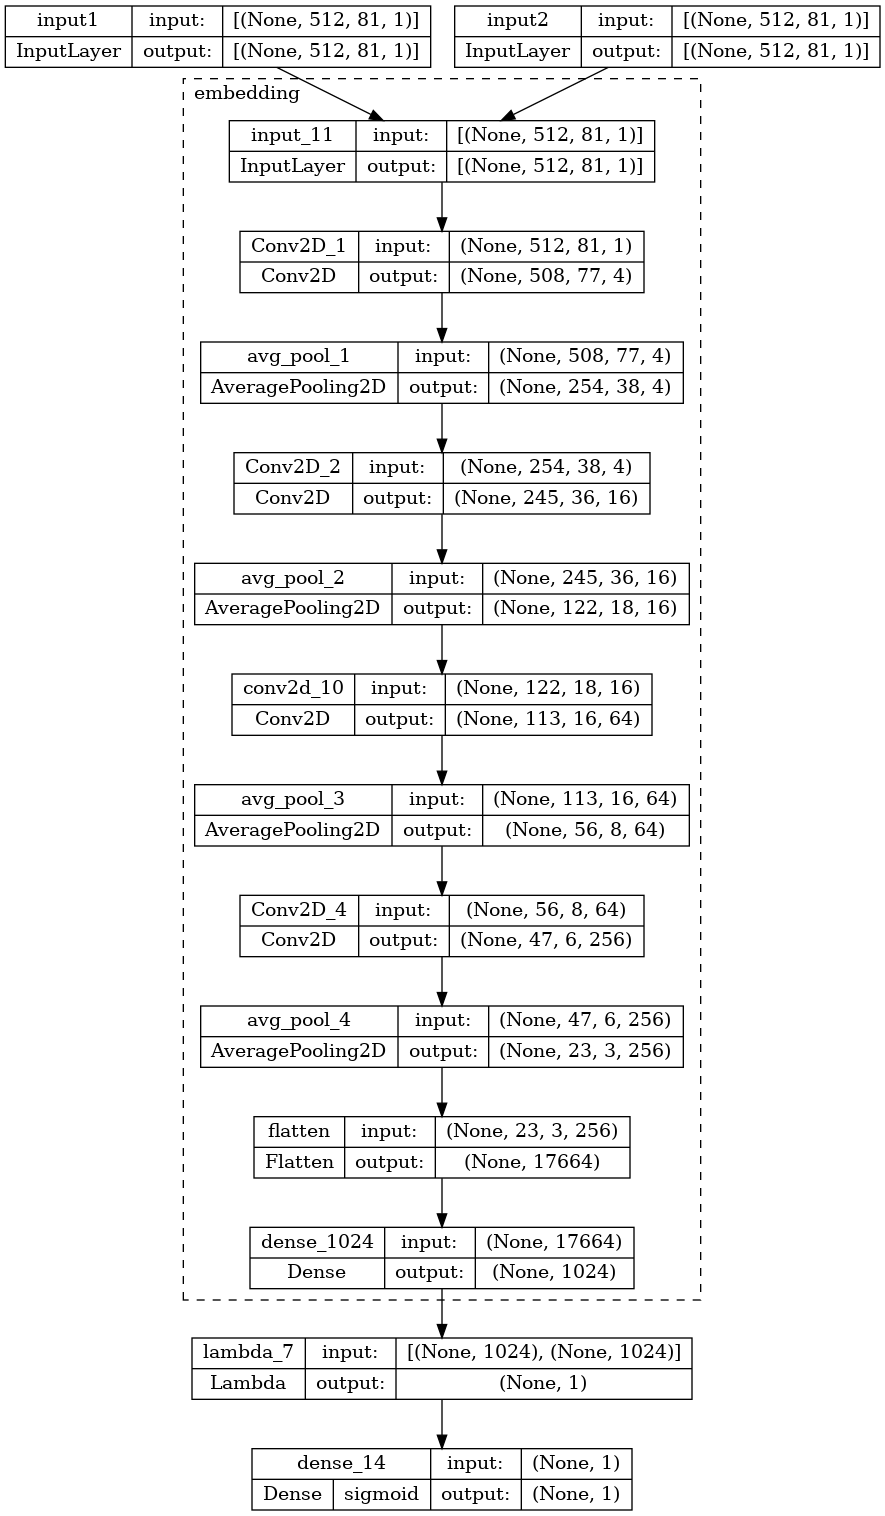

In [55]:
tf.keras.utils.plot_model(
    model,
    to_file="mod.png",
    show_shapes=True,
    expand_nested=True,
    show_layer_activations=True,
)

In [35]:
model.layers

In [64]:
input = tf.keras.layers.Input((512, 81, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = tf.keras.layers.Input((512, 81, 1), name="img1")
input_2 = tf.keras.layers.Input((512, 81, 1), name="img2")

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

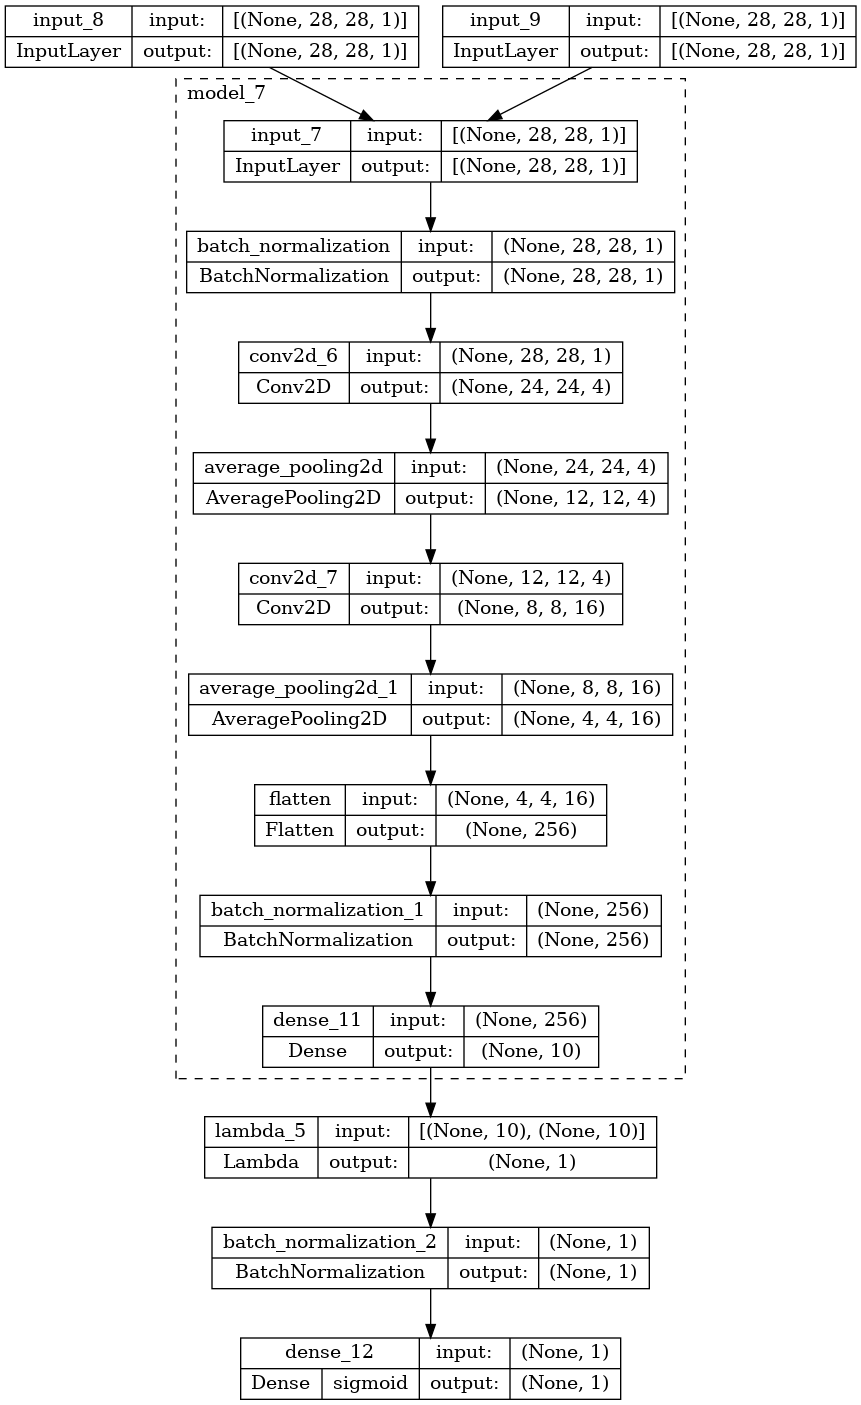

In [38]:
tf.keras.utils.plot_model(
    siamese,
    to_file="mod.png",
    show_shapes=True,
    expand_nested=True,
    show_layer_activations=True,
)

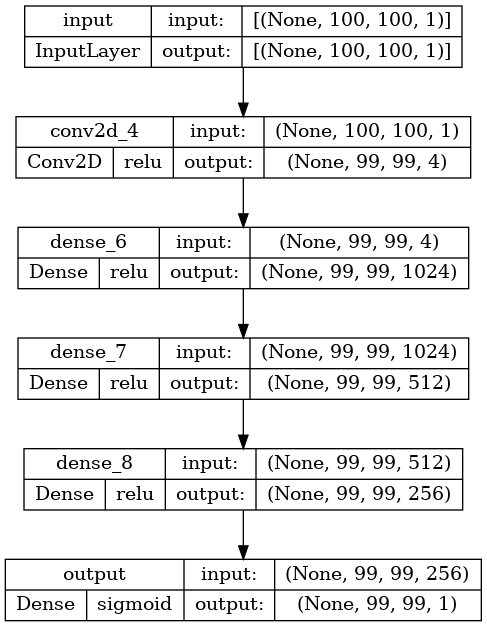

In [30]:
input = tf.keras.Input(shape=(100, 100, 1), dtype="float32", name="input")
x = tf.keras.layers.Conv2D(4, (2, 2), activation="relu")(input)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)
model = tf.keras.Model(inputs=[input], outputs=[output])
dot_img_file = "/tmp/model_1.png"
tf.keras.utils.plot_model(
    model,
    to_file="mod.png",
    show_shapes=True,
    expand_nested=True,
    show_layer_activations=True,
)

In [ ]:
plot_history(history.history)

## save

In [ ]:
def save_params(mod_dir, model, history, loss="constr", cfg):
    train_history = history.history
    min_val_loss_ix = np.argmin(train_history["val_loss"])
    max_acc = train_history["val_accuracy"][min_val_loss_ix]
    max_acc = int(np.round(max_acc * 1000))
    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{max_acc}.h5"),
    )
    config = {
        "loss": loss,
        "pos_label": cfg.pos_,
        "model": {
            "eff": False,
            "input_shape": INPUT_SIZE,
            "n_blocks": N_BLOCKS,
            "embedding_len": 1024,
            "kernel_size": (10, 3),
            "activation_fn": "relu",
            "batch_norm": False,
        },
        "history": train_history,
        "norm": NORM,
        "fold": FOLD,
    }

In [74]:
min_val_loss_ix = np.argmin(history.history["val_loss"])
max_acc = history.history["val_accuracy"][min_val_loss_ix]
max_acc = int(np.round(max_acc * 1000))

In [92]:
train_history = history.history
for k in train_history.keys():
    train_history[k] = list(map(float, train_history[k]))

In [77]:
model.save(
    os.path.join(mod_folder, f"model_{max_acc}.h5"),
)

In [94]:
config = {
    "loss": "constr",
    "pos_label": 0,
    "model": {
        "eff": False,
        "input_shape": (512, 81, 1),
        "n_blocks": 4,
        "embedding_len": 1024,
        "kernel_size": (10, 3),
        "activation_fn": "relu",
        "batch_norm": False,
    },
    "history": train_history,
    "norm": NORM,
    "fold": FOLD,
}

In [95]:
with open(os.path.join(mod_folder, "config.json"), "w") as f:
    json.dump(config, f)